# Missing Values

In [1]:
import os
from working_dir import set_wd
set_wd()
os.getcwd()

'/Users/tales.pimentel/ds/kaggle/football-match-prediction'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.sql.debug.maxToStringFields", 500) \
                            .config("spark.driver.memory", "14g") \
                            .appName("MissingValues").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StringIndexer
import pyspark.sql.functions as f
from src.dao import dao, dao_processed, dao_raw, dao_interim, dao_ml
from src.utils import dflib, stats, pretties, plot, plot_domain, palette

In [4]:
pretties.max_data_frame_columns()

# Loading Data

In [5]:
id_data = dao_processed.most_recent_data_build_id()
print(id_data)

04a4d619-00cc-4484-a724-e27e2161c91d


In [6]:
feature_selection_data = dao_ml.load_feature_selection(id_data=id_data)[0]

In [7]:
df_ttrain = dao_processed.load_processed_data(which_dataset="train_train", 
                                              id_data=id_data,
                                              spark=spark)

df_tvalid = dao_processed.load_processed_data(which_dataset="train_valid", 
                                              id_data=id_data,
                                              spark=spark)

df_test = dao_processed.load_processed_data(which_dataset="test", 
                                            id_data=id_data,
                                            spark=spark)

In [8]:
metadata = dao_processed.load_processed_metadata(id_data)

if "away_mood_diff" in metadata["use_features"]:
    metadata["use_features"].remove("away_mood_diff")

use_features = metadata["use_features"]

In [9]:
datasets = {"ttrain": df_ttrain, "tvalid": df_tvalid, "test": df_test}

# Checking missing values

In [10]:
for dataset_name in datasets.keys():
    pretties.md(dataset_name, size="##")
    df = datasets[dataset_name]
    len_features_na = dflib.filter_any_null(df, subset=use_features).count()
    if "target" in df.columns:
        len_target_na = dflib.filter_any_null(df, subset=["target"]).count()
        len_target_na = df.count()

    print(f"{len_features_na} rows with any feature null")
    print(f"{len_target_na} rows with target null")
    pretties.hr()

## <font color=black>ttrain</font>

2117 rows with any feature null
87470 rows with target null


## <font color=black>tvalid</font>

661 rows with any feature null
23468 rows with target null


## <font color=black>test</font>

6916 rows with any feature null
23468 rows with target null


In [11]:
null_data = []

for dataset_name in datasets.keys():
    df = datasets[dataset_name]
    
    for feature in use_features:
        feature_null = stats.freq(df.select(f.isnull(feature).alias(feature)), feature, round_n=4).toPandas().set_index(feature)
        if not True in feature_null.index:
            feature_null = feature_null.append(pd.DataFrame([{"Absolute": 0, "Relative": 0}], index=[True]))
        
        d = feature_null[["Relative"]].loc[True].to_dict()
        d["feature"] = feature
        d["dataset"] = dataset_name
        null_data.append(d)

null_df = pd.DataFrame(null_data).rename(columns={"Relative": "freq_null"})

# <font color=black>Null values rate by feature, over datasets</font>

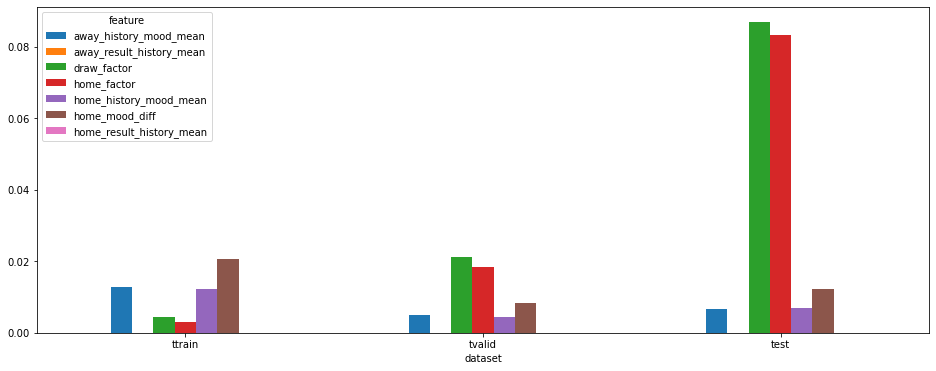

feature,away_history_mood_mean,away_result_history_mean,draw_factor,home_factor,home_history_mood_mean,home_mood_diff,home_result_history_mean
dataset,,,,,,,
ttrain,0.0127,0.0,0.0044,0.0029,0.0121,0.0205,0.0
tvalid,0.0049,0.0,0.0212,0.0183,0.0044,0.0083,0.0
test,0.0067,0.0,0.0868,0.0831,0.0069,0.0121,0.0


In [12]:
pretties.md("Null values rate by feature, over datasets")
null_df_pv = null_df.sort_values("freq_null").pivot(index="dataset", columns="feature", values="freq_null")
null_df_pv = null_df_pv.loc[["ttrain", "tvalid", "test"]]
null_df_pv.plot.bar(figsize=(16,6), rot=0)
plt.show()
display(null_df_pv)

### Notes

Around 8.5% of values are missing in `home_factor` and `draw_factor` features. <br>
These values are calculated for each `league_id` in the trainig dataset. <br>
If these values are missing for some league_id it could have happened on of two scenarios: <br>
 * The `ttrain` dataset doesn't have any matches of this league.
 * The number of matches is below the threshold set at `HomeFactorEstimator`'s parameter `n_matches_min`.
 
The good perspective is that the most missing values variables are the ones with less correlation with the `target` as you can see in the table below (generated by Feature Selection jupyter notebook). 

In [13]:
pd.DataFrame(feature_selection_data["anova"])

,f_statistic,p_value
home_mood_diff,3935.458008,0.000000e+00
away_mood_diff,3935.458008,0.000000e+00
home_history_mood_mean,1760.184204,0.000000e+00
away_history_mood_mean,1654.938354,0.000000e+00
home_result_history_mean,1308.731567,0.000000e+00
away_result_history_mean,1253.516113,0.000000e+00
draw_factor,836.310608,0.000000e+00
home_factor,541.662842,1.734726e-234
